In [18]:
# Imports
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import optuna
import joblib
from statistics import mean 

import torch

from darts import TimeSeries
from darts.models import BlockRNNModel, NBEATSModel, NHiTSModel, \
                        TCNModel, TFTModel
from darts.dataprocessing.transformers import Scaler


from darts.utils.likelihood_models import GaussianLikelihood

import warnings
warnings.filterwarnings('ignore')

# Configuration

In [19]:
prj_path = '../'
data_path = prj_path + "data/new_data/DH/squeezed/"
prj_path_opt= prj_path + "optimize_hyperparam/opt_results/"
output_process = prj_path + "data/new_data/DH/processed_data/"
output_featureselection = prj_path + "data/new_data/DH/feature_selection/"

In [20]:
all_cities = [
        'An Giang', 'BR Vũng Tàu', 'Bình Phước', 'Bình Thuận', 'Bình Định',
        'Bạc Liêu', 'Bắc Kạn', 'Bắc Giang', 'Cao Bằng', 'Cà Mau',
        'Cần Thơ', 'Gia Lai', 'Hà Giang', 'Hà Nội', 'Hà Tĩnh',
        'Hòa Bình','Hưng Yên', 'Hải Dương', 'Hải Phòng', 'Khánh Hòa', 'Kiên Giang',
        'Kon Tum', 'Lai Châu', 'Long An', 'Lào Cai', 'Lâm Đồng',
        'Lạng Sơn','Nam Định', 'Nghệ An', 'Ninh Bình', 'Ninh Thuận',
        'Phú Thọ', 'Phú Yên', 'Quảng Bình', 'Quảng Nam', 'Quảng Ngãi',
        'Quảng Ninh', 'Quảng Trị', 'Sóc Trăng', 'Sơn La', 'TT Huế',
        'Thanh Hóa', 'Thái Bình', 'Thái Nguyên', 'Tiền Giang', 'Trà Vinh',
        'Tuyên Quang', 'Tây Ninh', 'Vĩnh Phúc', 'Yên Bái', 'Điện Biên',
        'Đà Nẵng', 'Đắk Nông', 'Đắk Lắk', 'Đồng Tháp'
]
cities = [ 'Bình Phước', 'An Giang','Quảng Ninh']

In [21]:
# Set hyperparameters as args using the Configuration class
class Configuration():
    def __init__(self):
        # lấy bộ test dài 36 tháng = 3 năm
        self.test_size = 36
        # là nhìn vào dữ liệu trước 3 tháng và dự phóng        
        self.look_back = 3
        # dự phóng n-step trong 6 tháng
        self.n_predicted_period_months = 6
        self.n_features = 3
        self.seed = 42
        # mỗi phần tử x trong tập suppervise có độ lớn là 16 = 16 tháng
        self.batch_size = 16
        self.device = torch.device("cuda")
        self.epochs = 300
        #others
        self.labels = "Dengue_fever_rates"
        # Input param for Optimize Run
        self.ntry = 1
        self.njob = 1

args = Configuration()

# Seeding

In [22]:
def seed_everything(seed: int):
    import random
    import numpy as np
    import torch
    
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

seed_everything(args.seed)

# Supporting functions

In [23]:
import requests

def send_to_telegram(message):

    apiToken = '5908735099:AAGVSLrW62aXPBP-GrMvxoVgMsuJxXJpP1Q'
    chatID = '@ptn_announcement'
    apiURL = f'https://api.telegram.org/bot{apiToken}/sendMessage'

    try:
        response = requests.post(apiURL, json={'chat_id': chatID, 'text': message})
        print(response.text)
    except Exception as e:
        message_error = "Bị lỗi rùi: "+str(e)
        response = requests.post(apiURL, json={'chat_id': chatID, 'text': message_error})
        print(e)

In [24]:
def get_dict_all_city_data():
  cities_data = {}  
  for city in cities:
    city_result = pd.read_excel(prj_path+'data/new_data/DH/squeezed/squeezed_'+city+'.xlsx')  
    """Get all data from all city in 1997 - 2016""" 
    city_result = city_result.loc[city_result['year_month'] < '2017-1-1'] 
    cities_data[city] = city_result
  return cities_data

In [25]:
# Define data (pre-)processing functions
# modification
def get_city_data(city_name, dict_full_data):
    """Returns Dengue fever rate and climate data""" 
    city_data = dict_full_data[city_name].drop(columns=['Diarrhoea_cases','Diarrhoea_rates', 'province',
                                                        'Influenza_rates','Influenza_cases',
                                                        'Dengue_fever_cases', 'year', 'month'], 
                                                                  axis=1, 
                                                                  inplace=False)    
    return city_data

def convert_to_stationary(city_data):
    """Subtracts previous value for all cols except disease rates"""
    for col_name in city_data.columns:
        if col_name != 'Dengue_fever_rates':
            try:
                city_data[col_name] = city_data[col_name] - city_data[col_name].shift()
            except:
                print(col_name)
    return city_data

def impute_missing_value(city_data):
    """
    Imputes 0 for first 12 months, 
    last year's value for months 12-24, 
    and minimum value of last two years for months 25+
    """
    for col in city_data.columns:
        for index in range(len(city_data[col])):
            if np.isnan(city_data[col].iloc[index]):
                if index < 12:
                    city_data[col].iloc[index] = 0
                elif index >= 12 and index <= 24:
                    city_data[col].iloc[index] = city_data[col].iloc[index - 12]
                else:
                    city_data[col].iloc[index] = min(city_data[col].iloc[index - 12], city_data[col].iloc[index - 24])
    return city_data

In [26]:
def clean_full_data(dict_full_data):
    climate_and_disease_feats = ['Total_Evaporation',
       'Total_Rainfall', 'Max_Daily_Rainfall', 'n_raining_days',
       'Average_temperature', 'Max_Average_Temperature',
       'Min_Average_Temperature', 'Max_Absolute_Temperature',
       'Min_Absolute_Temperature', 'Average_Humidity', 'Min_Humidity',
       'n_hours_sunshine', 'Dengue_fever_rates']
    for city in cities:
        city_data = get_city_data(city_name=city,dict_full_data = dict_full_data)
        city_data_features = city_data[climate_and_disease_feats]
        city_data_features = impute_missing_value(city_data_features)
        city_data_features = convert_to_stationary(city_data_features)
        city_data_features.dropna(inplace=True)
        city_data_features.loc[:, "year_month"] = city_data["year_month"]
        dict_full_data[city] = city_data_features
    return dict_full_data


In [27]:
def split_data(data, look_back, n_nextstep = args.n_predicted_period_months):
    """Splits data into train and test sets based on args (Configuration class)"""
    train = data[: -args.test_size]    
    test = data[-args.test_size - look_back-(n_nextstep - 1): ]
    return train, test

In [28]:
def to_supervised(data,  d_out, d_in, features_list=[]):
    """
    Frames time-series as supervised learning dataset.
    
    Args:
      d_in: lookback window
      d_out: number of predicted months
      features_list: list of all features **where last col is the disease incidence**

    Returns:
      Numpy arrays of disease incidence (y) and other predictors (X)
    """
    X, y = list(), list()
    for index, _ in enumerate(data):
        in_end = index + d_in
        out_end = in_end + d_out
        if out_end <= len(data):
            if len(features_list) == 0 :
                X.append(data[index: in_end, :-1])
            else:
                X.append(data[index: in_end, features_list])
            y.append(data[out_end-1: out_end, -1])
    return np.array(X), np.array(y).reshape(len(y))

In [29]:
def getDataWithSelectedFeature(city, next_predicted_month):
  selected_feature = []
  df = pd.read_csv(output_featureselection+str(next_predicted_month)+"step_feature_selection_3_most.csv")
  for row in range(len(df)):
    if (df["City"][row] == city):
      selected_feature.append(df["1st_Feature"][row])
      selected_feature.append(df["2nd_Feature"][row])
      selected_feature.append(df["3rd_Feature"][row])
  return selected_feature

In [30]:
def train_and_evaluate(df_full, model, location, feature_list, labels, scaler):
    """
    $df: pandas.DataFrame object containing data for training and testing model:
    $model: darts model object
    $feature_list: Names of the features used as model input
    $label: the value the model will be trained to predict
    $scaler: scaler object. Note: the scaler will be fitted on training data and applied to test data
    $lags: how much to look back into the past to output prediction
    $split_index: the point at which to divide train and test_data

    """
    df_train, df_eval = split_data(df_full, args.look_back,args.n_predicted_period_months)
    
    print("🍋🍋🍋🍋🍋Check var feature selection: ",feature_list)
    x_train = TimeSeries.from_dataframe(df_train, "year_month", feature_list)
    y_train = TimeSeries.from_dataframe(df_train, "year_month", labels)
    x_test = TimeSeries.from_dataframe(df_eval, "year_month", feature_list)
    y_test = TimeSeries.from_dataframe(df_eval, "year_month", labels)

    #Cách một khoảng phần này cho x_train thì mới đưa đc chuỗi x_test vừa đủ để dự đoán 36 lần 6step
        # ValueError: For the given forecasting horizon `n=xxx`, the provided 
        # past covariates at dataset index `0` do not extend far enough into 
        # the future. As `n > output_chunk_length` the past covariates must 
        # start at time step `xxxxxx`, whereas now they start at 
        # time step `xxxxx`.

    x_train_back = x_train[:-(args.n_predicted_period_months-1)]
    y_train_back = y_train[:-(args.n_predicted_period_months-1)]

    predict_list = []
    for i in range (args.test_size+(args.n_predicted_period_months-1)):
        model.fit(y_train_back, past_covariates = x_train_back)
        prediction = model.predict(6)
        x_train_back = x_train_back.append(x_test[i+3])
        predict_list.append(np.array(prediction._xa).squeeze())
    y_pred_list = []
    for step in range(args.n_predicted_period_months):
        moving = args.n_predicted_period_months-1-step
        y_pred_list.append([x[step] for x in predict_list][moving:args.test_size+moving])

    df_eval_true_inverse = df_full[-args.test_size:]
    y_true = scaler.inverse_transform(df_eval_true_inverse.iloc[:,:-1])[:,[-1]].reshape(args.test_size)

    y_pred_inverse_list = []
    for step in range(args.n_predicted_period_months):
        df_eval_pred_inverse = df_full[-args.test_size:]
        df_eval_pred_inverse[args.labels]= y_pred_list[step] #step 1
        y_pred_inverse = scaler.inverse_transform(df_eval_pred_inverse.iloc[:,:-1])[:,[-1]].reshape(args.test_size)
        y_pred_inverse_list.append(y_pred_inverse)

    y_pred_inverse_list
    df_compare_test_predict = pd.DataFrame({
        'y_true':y_true,
        'y_pred_1step':y_pred_inverse_list[0],
        'y_pred_2step':y_pred_inverse_list[1],
        'y_pred_3step':y_pred_inverse_list[2],
        'y_pred_4step':y_pred_inverse_list[3],
        'y_pred_5step':y_pred_inverse_list[4],
        'y_pred_6step':y_pred_inverse_list[5],
        })
    df_compare_test_predict.plot()
    plt.legend()
    plt.show()
    mse_nstep = []
    mae_nstep = []
    rmse_nstep = []
    mape_nstep = []
    for step in range(args.n_predicted_period_months):
        mse_nstep.append(mean_squared_error(y_true, y_pred_inverse_list[step]))
        mae_nstep.append(mean_absolute_error(y_true, y_pred_inverse_list[step]))
        rmse_nstep.append(mse_nstep[step]**0.5)
        mape_nstep.append(mean_absolute_percentage_error(y_true, y_pred_inverse_list[step]))
    return model, y_true, y_pred_inverse_list, mse_nstep, mae_nstep, rmse_nstep, mape_nstep


In [31]:
def output_prediction_for_location(df_full, model, location, feature_list, 
                                                labels, scaler):
    """train and generate prediction for a province
    df: DataFrame object containing features and label(s) for training model
    localtion: location_name
    feature_list: list of features used as model input,  must be among the column names of df
    labels: the values model will be trained to predict
    scaler: sklearn scaler object
    lags: how long into the past to look back when making prediction
    split_index: the point at which to divide data into the train and test subsets.
    """
    model, y_true, y_pred_inverse_list, mse_nstep, mae_nstep, rmse_nstep, mape_nstep = train_and_evaluate(df_full, model, location, feature_list, labels, scaler)
    
    df_prediction = pd.DataFrame({"Date": df_full["year_month"][-args.test_size:],
                                  "Observed": y_true[-args.test_size:],
                                  f"{1}-month": y_pred_inverse_list[0],
                                  f"{2}-month": y_pred_inverse_list[1],
                                  f"{3}-month": y_pred_inverse_list[2],
                                  f"{4}-month": y_pred_inverse_list[3],
                                  f"{5}-month": y_pred_inverse_list[4],
                                  f"{6}-month": y_pred_inverse_list[5]})
    
    df_prediction["City"] = location
    for step in range(args.n_predicted_period_months):
        df_prediction[f"RMSE_{step+1}-month"] = rmse_nstep[step]
        df_prediction[f"MAE_{step+1}-month"] = mae_nstep[step]
        df_prediction[f"MAPE_{step+1}-month"] = mape_nstep[step]
        df_prediction[f"MSE_{step+1}-month"] = mse_nstep[step]
    print("⭐️⭐️⭐️⭐️⭐️⭐️⭐️")
    display(df_prediction.head(5))
    print(mean(mae_nstep))
    return mean(mae_nstep)

# Objective and Suggest Hyperparams of Darts Models


In [32]:
def objective(model_name, trial, city):   
    specific_data = pd.read_csv(output_process+city+'_train_preprocessed.csv', parse_dates=True, index_col= None, encoding = 'unicode_escape')
    scaler = joblib.load(output_process+city+'_train_scalerMinMaxNorm.save') #ok
    selected_features = getDataWithSelectedFeature(city, 6)    

    pl_trainer_kwargs = {
              "accelerator": "cpu",
              # "devices": -1,
              # "auto_select_gpus": True,
          }

    if model_name == "BlockRNNModel":
      #suggest hyperparams
      hidden_dim = trial.suggest_int('hidden_dim', 5, 20)
      n_rnn_layers = trial.suggest_int('n_rnn_layers', 1, 3)
      dropout = trial.suggest_uniform('dropout', 0.1, 0.5)
      n_epochs = trial.suggest_int('n_epochs', 50, 200)
      random_state = trial.suggest_int('random_state', 0, 1000)

      model = BlockRNNModel(
                          input_chunk_length = args.look_back,
                          output_chunk_length = args.n_predicted_period_months,
                          hidden_dim = hidden_dim,
                          n_rnn_layers = n_rnn_layers,
                          dropout = dropout,
                          n_epochs = 2,
                          pl_trainer_kwargs = pl_trainer_kwargs,
                          random_state=random_state)
    elif model_name == 'TFTModel':
      # Define the hyperparameters to optimize
      dropout = trial.suggest_uniform('dropout', 0.01, 0.8)
      n_epochs = trial.suggest_int('n_epochs', 50, 200)
      random_state = trial.suggest_int('random_state', 0, 42)
      # Create the TFTModel model
      model = TFTModel(
                    input_chunk_length = args.look_back,
                    output_chunk_length = args.n_predicted_period_months,
                    add_relative_index = True,
                    dropout = dropout,
                    n_epochs = 2,
                    pl_trainer_kwargs = pl_trainer_kwargs,
                    random_state=random_state)
    elif model_name == 'NHiTSModel':
      #suggest hyperparams
      MaxPool1d = trial.suggest_categorical('MaxPool1d', [True, False])
      dropout = trial.suggest_uniform('dropout', 0.01, 0.80)
      n_epochs = trial.suggest_int('n_epochs', 100, 500, step=10)
      random_state = trial.suggest_int('random_state', 0, 42)
      model = NHiTSModel(
                          input_chunk_length = args.look_back,
                          output_chunk_length = args.n_predicted_period_months,
                          MaxPool1d = MaxPool1d,
                          dropout = dropout,
                          n_epochs = 2 ,
                          pl_trainer_kwargs = pl_trainer_kwargs,
                          random_state=random_state)
    elif model_name == "NBEATSModel":
      dropout = trial.suggest_uniform('dropout', 0.01, 0.80)
      n_epochs = trial.suggest_int('n_epochs', 50, 200)
      random_state = trial.suggest_int('random_state', 0, 42)
      model = NBEATSModel(
                            input_chunk_length = args.look_back,
                            output_chunk_length = args.n_predicted_period_months,
                            dropout = dropout,
                            n_epochs = 2 ,
                            pl_trainer_kwargs = pl_trainer_kwargs,
                            random_state=random_state)
    elif model_name == "TCNModel":
      params = {
        'kernel_size': trial.suggest_int("kernel_size", 2, args.look_back),
        'num_filters': trial.suggest_int("num_filters", 1, 5),
        'weight_norm': trial.suggest_categorical("weight_norm", [False, True]),
        'dilation_base': trial.suggest_int("dilation_base", 2, 4),
        'dropout': trial.suggest_float("dropout", 0.0, 0.4),
        'learning_rate': trial.suggest_float("learning_rate", 5e-5, 1e-3, log=True),
        'include_year': trial.suggest_categorical("year", [False, True]),
        'n_epochs': trial.suggest_int("n_epochs", 100, 300),
      }
      # select input and output chunk lengths
      params['input_chunk_length'] = args.look_back
      params['output_chunk_length'] = args.n_predicted_period_months  
      # optionally also add the (scaled) year value as a past covariate
      if params['include_year']:
          encoders = {"datetime_attribute": {"past": ["year"]},
                      "transformer": Scaler()}
      else:
          encoders = None
      params['encoders'] = encoders
      param = params
      model = TCNModel(
          input_chunk_length=param['input_chunk_length'],
          output_chunk_length=param['output_chunk_length'],
          batch_size=16,
          n_epochs=param['n_epochs'],
          nr_epochs_val_period=1,
          kernel_size=param['kernel_size'],
          num_filters=param['num_filters'],
          weight_norm=param['weight_norm'],
          dilation_base=param['dilation_base'],
          dropout=param['dropout'],
          optimizer_kwargs={"lr": param['learning_rate']},
          add_encoders=param['encoders'],
          likelihood=GaussianLikelihood(),
          pl_trainer_kwargs=pl_trainer_kwargs,
          model_name="tcn_model",
          force_reset=True,
          save_checkpoints=True,
      )
    mae_error = output_prediction_for_location(specific_data, model, location=city, feature_list=selected_features,
                                                labels=args.labels, scaler=scaler)
    return mae_error

# Main run optimize and save

[I 2023-11-01 23:10:16,187] A new study created in memory with name: BlockRNNModel


⭐️ Model_name:  BlockRNNModel
⭐️ City:  Bình Phước


🍋🍋🍋🍋🍋Check var feature selection:  ['Max_Absolute_Temperature', 'Average_Humidity', 'Min_Humidity']


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | RNN              | 2.2 K 
4 | fc            | Sequential       | 126   
---------------------------------------------------
2.3 K     Trainable params
0         Non-trainable params
2.3 K     Total params
0.009     Total estimated model params size (MB)


Epoch 1: 100%|██████████| 5/5 [00:00<00:00, 185.21it/s, train_loss=0.0304]

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 5/5 [00:00<00:00, 176.16it/s, train_loss=0.0304]

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU avai

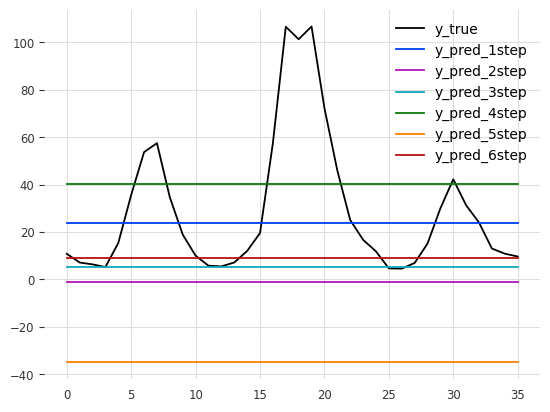

⭐️⭐️⭐️⭐️⭐️⭐️⭐️


,Date,Observed,1-month,2-month,3-month,4-month,5-month,6-month,City,RMSE_1-month,...,MAPE_4-month,MSE_4-month,RMSE_5-month,MAE_5-month,MAPE_5-month,MSE_5-month,RMSE_6-month,MAE_6-month,MAPE_6-month,MSE_6-month
167,2011-01-31,10.810211,23.749347,-1.21384,5.424764,40.217783,-35.035755,8.925276,Bình Phước,29.210223,...,2.348307,953.389651,70.139315,63.978579,3.756237,4919.523532,35.028092,21.516076,0.571328,1226.967198
168,2011-02-28,7.132503,23.749347,-1.21384,5.424764,40.217783,-35.035755,8.925276,Bình Phước,29.210223,...,2.348307,953.389651,70.139315,63.978579,3.756237,4919.523532,35.028092,21.516076,0.571328,1226.967198
169,2011-03-31,6.352378,23.749347,-1.21384,5.424764,40.217783,-35.035755,8.925276,Bình Phước,29.210223,...,2.348307,953.389651,70.139315,63.978579,3.756237,4919.523532,35.028092,21.516076,0.571328,1226.967198
170,2011-04-30,5.237939,23.749347,-1.21384,5.424764,40.217783,-35.035755,8.925276,Bình Phước,29.210223,...,2.348307,953.389651,70.139315,63.978579,3.756237,4919.523532,35.028092,21.516076,0.571328,1226.967198
171,2011-05-31,15.379464,23.749347,-1.21384,5.424764,40.217783,-35.035755,8.925276,Bình Phước,29.210223,...,2.348307,953.389651,70.139315,63.978579,3.756237,4919.523532,35.028092,21.516076,0.571328,1226.967198


[I 2023-11-01 23:10:19,224] Trial 0 finished with value: 31.173149498809607 and parameters: {'hidden_dim': 20, 'n_rnn_layers': 3, 'dropout': 0.21935364135667626, 'n_epochs': 115, 'random_state': 0}. Best is trial 0 with value: 31.173149498809607.
[I 2023-11-01 23:10:19,321] A new study created in memory with name: BlockRNNModel


31.173149498809607
Study statistics for : 
  Number of finished trials:  1
Best trial of city:  Bình Phước
⭐️ City:  An Giang
🍋🍋🍋🍋🍋Check var feature selection:  ['Max_Daily_Rainfall', 'Max_Absolute_Temperature', 'Average_Humidity']


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | RNN              | 700   
4 | fc            | Sequential       | 90    
---------------------------------------------------
790       Trainable params
0         Non-trainable params
790       Total params
0.003     Total estimated model params size (MB)


Epoch 1: 100%|██████████| 5/5 [00:00<00:00, 106.37it/s, train_loss=0.108]

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 5/5 [00:00<00:00, 103.14it/s, train_loss=0.108]

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU avai

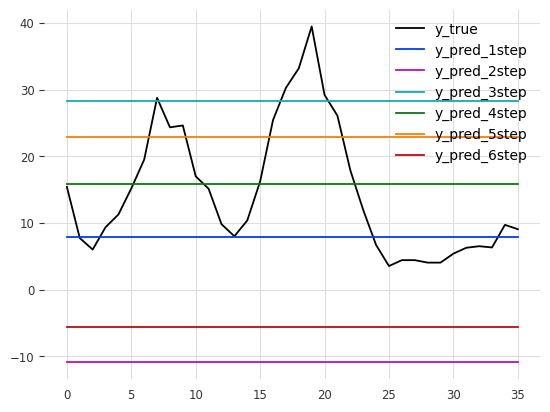

⭐️⭐️⭐️⭐️⭐️⭐️⭐️


,Date,Observed,1-month,2-month,3-month,4-month,5-month,6-month,City,RMSE_1-month,...,MAPE_4-month,MSE_4-month,RMSE_5-month,MAE_5-month,MAPE_5-month,MSE_5-month,RMSE_6-month,MAE_6-month,MAPE_6-month,MSE_6-month
167,2011-01-31,15.402509,7.900805,-10.940352,28.236511,15.821709,22.896778,-5.578748,An Giang,11.660593,...,0.954227,93.972011,12.749778,11.45436,1.572544,162.556828,22.268991,20.091055,1.603196,495.907972
168,2011-02-28,7.724528,7.900805,-10.940352,28.236511,15.821709,22.896778,-5.578748,An Giang,11.660593,...,0.954227,93.972011,12.749778,11.45436,1.572544,162.556828,22.268991,20.091055,1.603196,495.907972
169,2011-03-31,6.002788,7.900805,-10.940352,28.236511,15.821709,22.896778,-5.578748,An Giang,11.660593,...,0.954227,93.972011,12.749778,11.45436,1.572544,162.556828,22.268991,20.091055,1.603196,495.907972
170,2011-04-30,9.353184,7.900805,-10.940352,28.236511,15.821709,22.896778,-5.578748,An Giang,11.660593,...,0.954227,93.972011,12.749778,11.45436,1.572544,162.556828,22.268991,20.091055,1.603196,495.907972
171,2011-05-31,11.261053,7.900805,-10.940352,28.236511,15.821709,22.896778,-5.578748,An Giang,11.660593,...,0.954227,93.972011,12.749778,11.45436,1.572544,162.556828,22.268991,20.091055,1.603196,495.907972


[I 2023-11-01 23:10:20,915] Trial 0 finished with value: 14.731491314623682 and parameters: {'hidden_dim': 14, 'n_rnn_layers': 2, 'dropout': 0.2863357401620268, 'n_epochs': 176, 'random_state': 442}. Best is trial 0 with value: 14.731491314623682.
[I 2023-11-01 23:10:20,934] A new study created in memory with name: BlockRNNModel
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | RNN              | 216   
4 | fc            | Sequential       | 78    
---------------------------------------------------
294       Trainable params
0         Non-trainable params
294       Total params
0.001     Total estimated model params size (MB)


14.731491314623682
Study statistics for : 
  Number of finished trials:  1
Best trial of city:  An Giang
⭐️ City:  Quảng Ninh
🍋🍋🍋🍋🍋Check var feature selection:  ['Max_Daily_Rainfall', 'n_raining_days', 'n_hours_sunshine']
Epoch 1: 100%|██████████| 5/5 [00:00<00:00, 74.17it/s, train_loss=0.0549]

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 5/5 [00:00<00:00, 72.29it/s, train_loss=0.0549]

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU avai

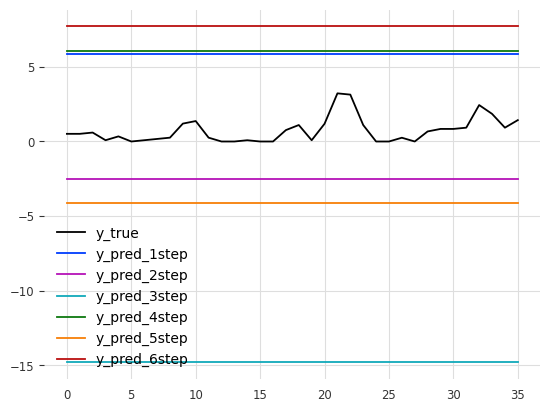

⭐️⭐️⭐️⭐️⭐️⭐️⭐️


,Date,Observed,1-month,2-month,3-month,4-month,5-month,6-month,City,RMSE_1-month,...,MAPE_4-month,MSE_4-month,RMSE_5-month,MAE_5-month,MAPE_5-month,MSE_5-month,RMSE_6-month,MAE_6-month,MAPE_6-month,MSE_6-month
167,2011-01-31,0.513699,5.892834,-2.537513,-14.808008,6.072038,-4.145285,7.707655,Quảng Ninh,5.229952,...,6.076895e+15,29.234896,4.946427,4.875344,4.148601e+15,24.467136,7.027446,6.977596,7.713820e+15,49.385
168,2011-02-28,0.513699,5.892834,-2.537513,-14.808008,6.072038,-4.145285,7.707655,Quảng Ninh,5.229952,...,6.076895e+15,29.234896,4.946427,4.875344,4.148601e+15,24.467136,7.027446,6.977596,7.713820e+15,49.385
169,2011-03-31,0.599316,5.892834,-2.537513,-14.808008,6.072038,-4.145285,7.707655,Quảng Ninh,5.229952,...,6.076895e+15,29.234896,4.946427,4.875344,4.148601e+15,24.467136,7.027446,6.977596,7.713820e+15,49.385
170,2011-04-30,0.085617,5.892834,-2.537513,-14.808008,6.072038,-4.145285,7.707655,Quảng Ninh,5.229952,...,6.076895e+15,29.234896,4.946427,4.875344,4.148601e+15,24.467136,7.027446,6.977596,7.713820e+15,49.385
171,2011-05-31,0.342464,5.892834,-2.537513,-14.808008,6.072038,-4.145285,7.707655,Quảng Ninh,5.229952,...,6.076895e+15,29.234896,4.946427,4.875344,4.148601e+15,24.467136,7.027446,6.977596,7.713820e+15,49.385


[I 2023-11-01 23:10:22,277] Trial 0 finished with value: 6.86055555246503 and parameters: {'hidden_dim': 12, 'n_rnn_layers': 1, 'dropout': 0.16489513305953946, 'n_epochs': 75, 'random_state': 227}. Best is trial 0 with value: 6.86055555246503.
[I 2023-11-01 23:10:22,297] A new study created in memory with name: NBEATSModel
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 6.1 M 
---------------------------------------------------
6.1 M     Trainable params
1.4 K     Non-trainable params
6.1 M     Total params
24.419    Total estimated model params size (MB)


6.86055555246503
Study statistics for : 
  Number of finished trials:  1
Best trial of city:  Quảng Ninh
⭐️ Model_name:  NBEATSModel
⭐️ City:  Bình Phước
🍋🍋🍋🍋🍋Check var feature selection:  ['Max_Absolute_Temperature', 'Average_Humidity', 'Min_Humidity']
Epoch 1: 100%|██████████| 5/5 [00:00<00:00, 11.13it/s, train_loss=0.070] 

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 5/5 [00:00<00:00, 11.08it/s, train_loss=0.070]


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU avai

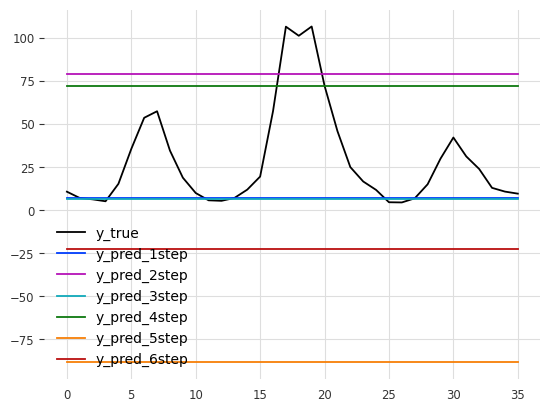

⭐️⭐️⭐️⭐️⭐️⭐️⭐️


,Date,Observed,1-month,2-month,3-month,4-month,5-month,6-month,City,RMSE_1-month,...,MAPE_4-month,MSE_4-month,RMSE_5-month,MAE_5-month,MAPE_5-month,MSE_5-month,RMSE_6-month,MAE_6-month,MAPE_6-month,MSE_6-month
167,2011-01-31,10.810211,7.2147,79.121031,6.731349,71.959653,-88.354228,-22.575773,Bình Phước,36.032989,...,4.71352,2676.712454,120.767808,117.297052,7.950763,14584.863471,58.995176,51.518597,2.77602,3480.430812
168,2011-02-28,7.132503,7.2147,79.121031,6.731349,71.959653,-88.354228,-22.575773,Bình Phước,36.032989,...,4.71352,2676.712454,120.767808,117.297052,7.950763,14584.863471,58.995176,51.518597,2.77602,3480.430812
169,2011-03-31,6.352378,7.2147,79.121031,6.731349,71.959653,-88.354228,-22.575773,Bình Phước,36.032989,...,4.71352,2676.712454,120.767808,117.297052,7.950763,14584.863471,58.995176,51.518597,2.77602,3480.430812
170,2011-04-30,5.237939,7.2147,79.121031,6.731349,71.959653,-88.354228,-22.575773,Bình Phước,36.032989,...,4.71352,2676.712454,120.767808,117.297052,7.950763,14584.863471,58.995176,51.518597,2.77602,3480.430812
171,2011-05-31,15.379464,7.2147,79.121031,6.731349,71.959653,-88.354228,-22.575773,Bình Phước,36.032989,...,4.71352,2676.712454,120.767808,117.297052,7.950763,14584.863471,58.995176,51.518597,2.77602,3480.430812


[I 2023-11-01 23:10:25,458] Trial 0 finished with value: 52.80896727960917 and parameters: {'dropout': 0.525314294469156, 'n_epochs': 96, 'random_state': 12}. Best is trial 0 with value: 52.80896727960917.
[I 2023-11-01 23:10:25,497] A new study created in memory with name: NBEATSModel
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


52.80896727960917
Study statistics for : 
  Number of finished trials:  1
Best trial of city:  Bình Phước
⭐️ City:  An Giang
🍋🍋🍋🍋🍋Check var feature selection:  ['Max_Daily_Rainfall', 'Max_Absolute_Temperature', 'Average_Humidity']



  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 6.1 M 
---------------------------------------------------
6.1 M     Trainable params
1.4 K     Non-trainable params
6.1 M     Total params
24.419    Total estimated model params size (MB)


Epoch 1: 100%|██████████| 5/5 [00:00<00:00,  9.77it/s, train_loss=0.212]

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 5/5 [00:00<00:00,  9.74it/s, train_loss=0.212]

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU avai

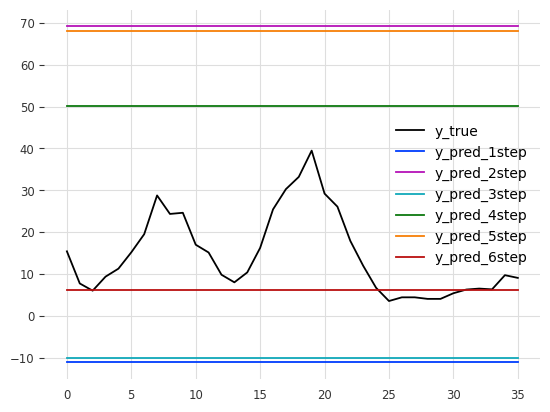

⭐️⭐️⭐️⭐️⭐️⭐️⭐️


,Date,Observed,1-month,2-month,3-month,4-month,5-month,6-month,City,RMSE_1-month,...,MAPE_4-month,MSE_4-month,RMSE_5-month,MAE_5-month,MAPE_5-month,MSE_5-month,RMSE_6-month,MAE_6-month,MAPE_6-month,MSE_6-month
167,2011-01-31,15.402509,-11.155011,69.12935,-10.155993,50.196833,68.037706,6.180687,An Giang,27.405632,...,4.427476,1365.642868,54.380381,53.525399,6.3565,2957.225812,12.715084,8.967243,0.486693,161.673373
168,2011-02-28,7.724528,-11.155011,69.12935,-10.155993,50.196833,68.037706,6.180687,An Giang,27.405632,...,4.427476,1365.642868,54.380381,53.525399,6.3565,2957.225812,12.715084,8.967243,0.486693,161.673373
169,2011-03-31,6.002788,-11.155011,69.12935,-10.155993,50.196833,68.037706,6.180687,An Giang,27.405632,...,4.427476,1365.642868,54.380381,53.525399,6.3565,2957.225812,12.715084,8.967243,0.486693,161.673373
170,2011-04-30,9.353184,-11.155011,69.12935,-10.155993,50.196833,68.037706,6.180687,An Giang,27.405632,...,4.427476,1365.642868,54.380381,53.525399,6.3565,2957.225812,12.715084,8.967243,0.486693,161.673373
171,2011-05-31,11.261053,-11.155011,69.12935,-10.155993,50.196833,68.037706,6.180687,An Giang,27.405632,...,4.427476,1365.642868,54.380381,53.525399,6.3565,2957.225812,12.715084,8.967243,0.486693,161.673373


[I 2023-11-01 23:10:28,839] Trial 0 finished with value: 33.85497136517201 and parameters: {'dropout': 0.744285672510434, 'n_epochs': 189, 'random_state': 23}. Best is trial 0 with value: 33.85497136517201.
[I 2023-11-01 23:10:28,866] A new study created in memory with name: NBEATSModel
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


33.85497136517201
Study statistics for : 
  Number of finished trials:  1
Best trial of city:  An Giang
⭐️ City:  Quảng Ninh
🍋🍋🍋🍋🍋Check var feature selection:  ['Max_Daily_Rainfall', 'n_raining_days', 'n_hours_sunshine']



  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 6.1 M 
---------------------------------------------------
6.1 M     Trainable params
1.4 K     Non-trainable params
6.1 M     Total params
24.419    Total estimated model params size (MB)


Epoch 1: 100%|██████████| 5/5 [00:00<00:00,  8.34it/s, train_loss=0.0718]

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 5/5 [00:00<00:00,  8.33it/s, train_loss=0.0718]


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU avai

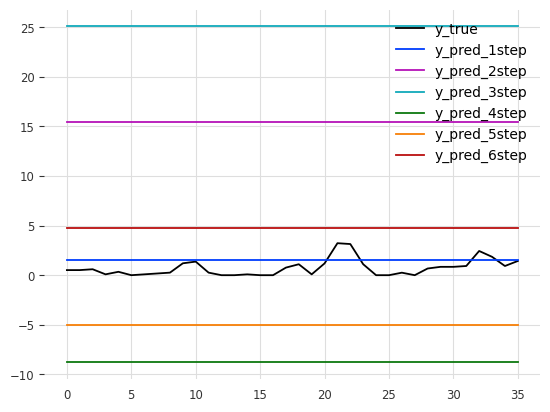

⭐️⭐️⭐️⭐️⭐️⭐️⭐️


,Date,Observed,1-month,2-month,3-month,4-month,5-month,6-month,City,RMSE_1-month,...,MAPE_4-month,MSE_4-month,RMSE_5-month,MAE_5-month,MAPE_5-month,MSE_5-month,RMSE_6-month,MAE_6-month,MAPE_6-month,MSE_6-month
167,2011-01-31,0.513699,1.486434,15.490588,25.085699,-8.80416,-5.038379,4.753276,Quảng Ninh,1.127057,...,8.811202e+15,91.599477,5.828639,5.768438,5.042410e+15,33.973036,4.109067,4.023217,4.757079e+15,16.884433
168,2011-02-28,0.513699,1.486434,15.490588,25.085699,-8.80416,-5.038379,4.753276,Quảng Ninh,1.127057,...,8.811202e+15,91.599477,5.828639,5.768438,5.042410e+15,33.973036,4.109067,4.023217,4.757079e+15,16.884433
169,2011-03-31,0.599316,1.486434,15.490588,25.085699,-8.80416,-5.038379,4.753276,Quảng Ninh,1.127057,...,8.811202e+15,91.599477,5.828639,5.768438,5.042410e+15,33.973036,4.109067,4.023217,4.757079e+15,16.884433
170,2011-04-30,0.085617,1.486434,15.490588,25.085699,-8.80416,-5.038379,4.753276,Quảng Ninh,1.127057,...,8.811202e+15,91.599477,5.828639,5.768438,5.042410e+15,33.973036,4.109067,4.023217,4.757079e+15,16.884433
171,2011-05-31,0.342464,1.486434,15.490588,25.085699,-8.80416,-5.038379,4.753276,Quảng Ninh,1.127057,...,8.811202e+15,91.599477,5.828639,5.768438,5.042410e+15,33.973036,4.109067,4.023217,4.757079e+15,16.884433


[I 2023-11-01 23:10:34,862] Trial 0 finished with value: 9.910082233474373 and parameters: {'dropout': 0.4311245494021748, 'n_epochs': 180, 'random_state': 26}. Best is trial 0 with value: 9.910082233474373.


9.910082233474373
Study statistics for : 
  Number of finished trials:  1
Best trial of city:  Quảng Ninh


[I 2023-11-01 23:10:34,987] A new study created in memory with name: NHiTSModel


⭐️ Model_name:  NHiTSModel
⭐️ City:  Bình Phước
🍋🍋🍋🍋🍋Check var feature selection:  ['Max_Absolute_Temperature', 'Average_Humidity', 'Min_Humidity']


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 851 K 
---------------------------------------------------
844 K     Trainable params
6.2 K     Non-trainable params
851 K     Total params
3.404     Total estimated model params size (MB)


Epoch 1: 100%|██████████| 5/5 [00:00<00:00, 31.07it/s, train_loss=0.0767]

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 5/5 [00:00<00:00, 30.39it/s, train_loss=0.0767]


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU avai

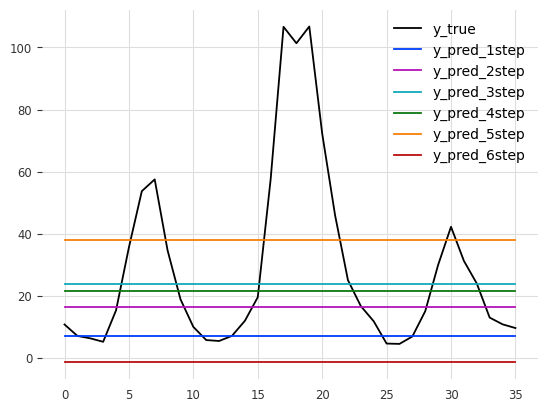

⭐️⭐️⭐️⭐️⭐️⭐️⭐️


,Date,Observed,1-month,2-month,3-month,4-month,5-month,6-month,City,RMSE_1-month,...,MAPE_4-month,MSE_4-month,RMSE_5-month,MAE_5-month,MAPE_5-month,MSE_5-month,RMSE_6-month,MAE_6-month,MAPE_6-month,MSE_6-month
167,2011-01-31,10.810211,7.211753,16.318581,23.808291,21.426467,38.147143,-1.417942,Bình Phước,36.034767,...,1.108271,882.760577,30.182519,25.906083,2.20166,910.984428,41.809581,30.360767,1.111548,1748.041095
168,2011-02-28,7.132503,7.211753,16.318581,23.808291,21.426467,38.147143,-1.417942,Bình Phước,36.034767,...,1.108271,882.760577,30.182519,25.906083,2.20166,910.984428,41.809581,30.360767,1.111548,1748.041095
169,2011-03-31,6.352378,7.211753,16.318581,23.808291,21.426467,38.147143,-1.417942,Bình Phước,36.034767,...,1.108271,882.760577,30.182519,25.906083,2.20166,910.984428,41.809581,30.360767,1.111548,1748.041095
170,2011-04-30,5.237939,7.211753,16.318581,23.808291,21.426467,38.147143,-1.417942,Bình Phước,36.034767,...,1.108271,882.760577,30.182519,25.906083,2.20166,910.984428,41.809581,30.360767,1.111548,1748.041095
171,2011-05-31,15.379464,7.211753,16.318581,23.808291,21.426467,38.147143,-1.417942,Bình Phước,36.034767,...,1.108271,882.760577,30.182519,25.906083,2.20166,910.984428,41.809581,30.360767,1.111548,1748.041095


[I 2023-11-01 23:10:44,141] Trial 0 finished with value: 23.309567318051883 and parameters: {'MaxPool1d': False, 'dropout': 0.7754277403987049, 'n_epochs': 220, 'random_state': 19}. Best is trial 0 with value: 23.309567318051883.


23.309567318051883
Study statistics for : 
  Number of finished trials:  1
Best trial of city:  Bình Phước


[I 2023-11-01 23:10:44,558] A new study created in memory with name: NHiTSModel
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 851 K 
---------------------------------------------------
844 K     Trainable params
6.2 K     Non-trainable params
851 K     Total params
3.404     Total estimated model params size (MB)


⭐️ City:  An Giang
🍋🍋🍋🍋🍋Check var feature selection:  ['Max_Daily_Rainfall', 'Max_Absolute_Temperature', 'Average_Humidity']
Epoch 1: 100%|██████████| 5/5 [00:00<00:00, 35.01it/s, train_loss=0.0602]

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 5/5 [00:00<00:00, 34.47it/s, train_loss=0.0602]


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU avai

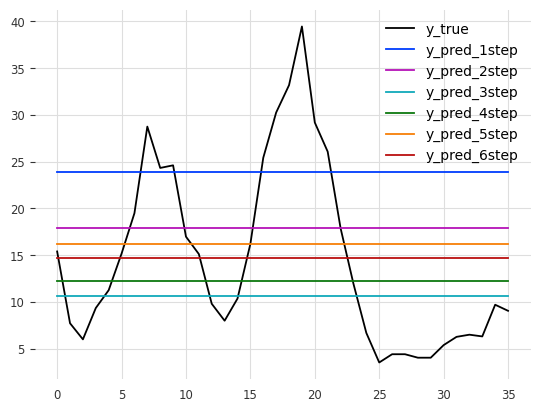

⭐️⭐️⭐️⭐️⭐️⭐️⭐️


,Date,Observed,1-month,2-month,3-month,4-month,5-month,6-month,City,RMSE_1-month,...,MAPE_4-month,MSE_4-month,RMSE_5-month,MAE_5-month,MAPE_5-month,MSE_5-month,RMSE_6-month,MAE_6-month,MAPE_6-month,MSE_6-month
167,2011-01-31,15.402509,23.920661,17.957387,10.648614,12.281901,16.237328,14.750089,An Giang,13.445244,...,0.710859,97.232187,9.758749,8.439473,0.986637,95.233176,9.608018,8.105883,0.876043,92.314017
168,2011-02-28,7.724528,23.920661,17.957387,10.648614,12.281901,16.237328,14.750089,An Giang,13.445244,...,0.710859,97.232187,9.758749,8.439473,0.986637,95.233176,9.608018,8.105883,0.876043,92.314017
169,2011-03-31,6.002788,23.920661,17.957387,10.648614,12.281901,16.237328,14.750089,An Giang,13.445244,...,0.710859,97.232187,9.758749,8.439473,0.986637,95.233176,9.608018,8.105883,0.876043,92.314017
170,2011-04-30,9.353184,23.920661,17.957387,10.648614,12.281901,16.237328,14.750089,An Giang,13.445244,...,0.710859,97.232187,9.758749,8.439473,0.986637,95.233176,9.608018,8.105883,0.876043,92.314017
171,2011-05-31,11.261053,23.920661,17.957387,10.648614,12.281901,16.237328,14.750089,An Giang,13.445244,...,0.710859,97.232187,9.758749,8.439473,0.986637,95.233176,9.608018,8.105883,0.876043,92.314017


[I 2023-11-01 23:10:47,876] Trial 0 finished with value: 8.8616383916928 and parameters: {'MaxPool1d': False, 'dropout': 0.7208164822702615, 'n_epochs': 230, 'random_state': 15}. Best is trial 0 with value: 8.8616383916928.
[I 2023-11-01 23:10:47,917] A new study created in memory with name: NHiTSModel
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 851 K 
---------------------------------------------------
844 K     Trainable params
6.2 K     Non-trainable params
851 K     Total params
3.404     Total estimated model params size (MB)


8.8616383916928
Study statistics for : 
  Number of finished trials:  1
Best trial of city:  An Giang
⭐️ City:  Quảng Ninh
🍋🍋🍋🍋🍋Check var feature selection:  ['Max_Daily_Rainfall', 'n_raining_days', 'n_hours_sunshine']
Epoch 1: 100%|██████████| 5/5 [00:00<00:00, 40.10it/s, train_loss=0.0335]

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 5/5 [00:00<00:00, 39.18it/s, train_loss=0.0335]


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU avai

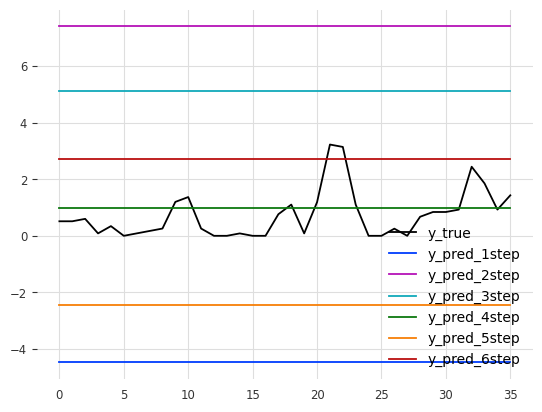

⭐️⭐️⭐️⭐️⭐️⭐️⭐️


,Date,Observed,1-month,2-month,3-month,4-month,5-month,6-month,City,RMSE_1-month,...,MAPE_4-month,MSE_4-month,RMSE_5-month,MAE_5-month,MAPE_5-month,MSE_5-month,RMSE_6-month,MAE_6-month,MAPE_6-month,MSE_6-month
167,2011-01-31,0.513699,-4.477618,7.399986,5.115765,0.996894,-2.431883,2.701099,Quảng Ninh,5.274282,...,9.976918e+14,0.769355,3.270478,3.161942,2.433828e+15,10.696029,2.14083,2.024715,2.703259e+15,4.583152
168,2011-02-28,0.513699,-4.477618,7.399986,5.115765,0.996894,-2.431883,2.701099,Quảng Ninh,5.274282,...,9.976918e+14,0.769355,3.270478,3.161942,2.433828e+15,10.696029,2.14083,2.024715,2.703259e+15,4.583152
169,2011-03-31,0.599316,-4.477618,7.399986,5.115765,0.996894,-2.431883,2.701099,Quảng Ninh,5.274282,...,9.976918e+14,0.769355,3.270478,3.161942,2.433828e+15,10.696029,2.14083,2.024715,2.703259e+15,4.583152
170,2011-04-30,0.085617,-4.477618,7.399986,5.115765,0.996894,-2.431883,2.701099,Quảng Ninh,5.274282,...,9.976918e+14,0.769355,3.270478,3.161942,2.433828e+15,10.696029,2.14083,2.024715,2.703259e+15,4.583152
171,2011-05-31,0.342464,-4.477618,7.399986,5.115765,0.996894,-2.431883,2.701099,Quảng Ninh,5.274282,...,9.976918e+14,0.769355,3.270478,3.161942,2.433828e+15,10.696029,2.14083,2.024715,2.703259e+15,4.583152


[I 2023-11-01 23:10:49,962] Trial 0 finished with value: 3.6943804417760657 and parameters: {'MaxPool1d': False, 'dropout': 0.3294939458748122, 'n_epochs': 410, 'random_state': 19}. Best is trial 0 with value: 3.6943804417760657.
[I 2023-11-01 23:10:49,996] A new study created in memory with name: TFTModel
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

   | Name                              | Type                             | Params
----------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0     
1  | val_metrics                       | MetricCollection                 | 0     
2  | input_embeddings                  | _MultiEmbedding                  | 0     
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0     
4  | encoder_vsn                   

3.6943804417760657
Study statistics for : 
  Number of finished trials:  1
Best trial of city:  Quảng Ninh
⭐️ Model_name:  TFTModel
⭐️ City:  Bình Phước
🍋🍋🍋🍋🍋Check var feature selection:  ['Max_Absolute_Temperature', 'Average_Humidity', 'Min_Humidity']
Epoch 1: 100%|██████████| 5/5 [00:00<00:00, 45.04it/s, train_loss=2.430]

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 5/5 [00:00<00:00, 44.71it/s, train_loss=2.430]

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU avai

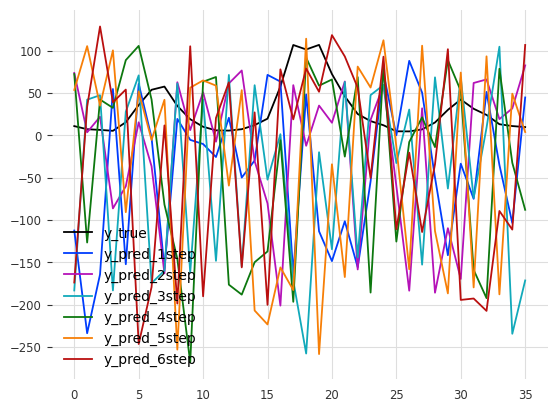

⭐️⭐️⭐️⭐️⭐️⭐️⭐️


,Date,Observed,1-month,2-month,3-month,4-month,5-month,6-month,City,RMSE_1-month,...,MAPE_4-month,MSE_4-month,RMSE_5-month,MAE_5-month,MAPE_5-month,MSE_5-month,RMSE_6-month,MAE_6-month,MAPE_6-month,MSE_6-month
167,2011-01-31,10.810211,-112.544536,73.593110,-183.311860,72.303190,53.490552,-173.911734,Bình Phước,118.60575,...,7.224102,15818.177563,145.941551,112.387423,6.984539,21298.936326,132.086302,105.881487,7.279863,17446.791303
168,2011-02-28,7.132503,-233.820051,3.516226,42.034781,-126.697321,105.266082,33.671134,Bình Phước,118.60575,...,7.224102,15818.177563,145.941551,112.387423,6.984539,21298.936326,132.086302,105.881487,7.279863,17446.791303
169,2011-03-31,6.352378,-164.365806,21.837243,47.291171,42.182696,34.954696,128.477637,Bình Phước,118.60575,...,7.224102,15818.177563,145.941551,112.387423,6.984539,21298.936326,132.086302,105.881487,7.279863,17446.791303
170,2011-04-30,5.237939,54.613485,-86.391538,-183.250836,32.343102,100.276347,38.905168,Bình Phước,118.60575,...,7.224102,15818.177563,145.941551,112.387423,6.984539,21298.936326,132.086302,105.881487,7.279863,17446.791303
171,2011-05-31,15.379464,-152.311524,-60.270456,27.830810,88.712351,-90.877513,53.953379,Bình Phước,118.60575,...,7.224102,15818.177563,145.941551,112.387423,6.984539,21298.936326,132.086302,105.881487,7.279863,17446.791303


[I 2023-11-01 23:10:52,375] Trial 0 finished with value: 99.31228494867686 and parameters: {'dropout': 0.2852239201243291, 'n_epochs': 166, 'random_state': 1}. Best is trial 0 with value: 99.31228494867686.
[I 2023-11-01 23:10:52,395] A new study created in memory with name: TFTModel
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

   | Name                              | Type                             | Params
----------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0     
1  | val_metrics                       | MetricCollection                 | 0     
2  | input_embeddings                  | _MultiEmbedding                  | 0     
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0     
4  | encoder_vsn                       | _VariableSelectio

99.31228494867686
Study statistics for : 
  Number of finished trials:  1
Best trial of city:  Bình Phước
⭐️ City:  An Giang
🍋🍋🍋🍋🍋Check var feature selection:  ['Max_Daily_Rainfall', 'Max_Absolute_Temperature', 'Average_Humidity']
Epoch 1: 100%|██████████| 5/5 [00:00<00:00, 11.31it/s, train_loss=2.700]

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 5/5 [00:00<00:00, 11.27it/s, train_loss=2.700]


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU avai

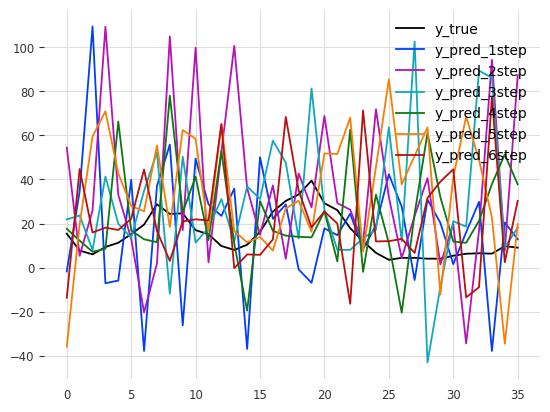

⭐️⭐️⭐️⭐️⭐️⭐️⭐️


,Date,Observed,1-month,2-month,3-month,4-month,5-month,6-month,City,RMSE_1-month,...,MAPE_4-month,MSE_4-month,RMSE_5-month,MAE_5-month,MAPE_5-month,MSE_5-month,RMSE_6-month,MAE_6-month,MAPE_6-month,MSE_6-month
167,2011-01-31,15.402509,-1.761119,54.435136,21.834706,17.630103,-35.837243,-13.674292,An Giang,31.202664,...,2.223076,654.980146,36.048722,29.087195,3.894222,1299.510334,25.688176,19.104105,2.202888,659.882395
168,2011-02-28,7.724528,34.650623,5.326124,23.651553,12.206867,19.629011,44.733352,An Giang,31.202664,...,2.223076,654.980146,36.048722,29.087195,3.894222,1299.510334,25.688176,19.104105,2.202888,659.882395
169,2011-03-31,6.002788,109.421315,25.966882,8.007717,7.180674,59.452758,15.923812,An Giang,31.202664,...,2.223076,654.980146,36.048722,29.087195,3.894222,1299.510334,25.688176,19.104105,2.202888,659.882395
170,2011-04-30,9.353184,-7.111705,109.326918,41.322519,8.533486,70.944332,18.132788,An Giang,31.202664,...,2.223076,654.980146,36.048722,29.087195,3.894222,1299.510334,25.688176,19.104105,2.202888,659.882395
171,2011-05-31,11.261053,-5.890084,33.019162,19.844206,66.285561,42.724024,17.065664,An Giang,31.202664,...,2.223076,654.980146,36.048722,29.087195,3.894222,1299.510334,25.688176,19.104105,2.202888,659.882395


[I 2023-11-01 23:10:54,650] Trial 0 finished with value: 24.182575737565298 and parameters: {'dropout': 0.6676061305672648, 'n_epochs': 62, 'random_state': 34}. Best is trial 0 with value: 24.182575737565298.
[I 2023-11-01 23:10:54,690] A new study created in memory with name: TFTModel
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

   | Name                              | Type                             | Params
----------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0     
1  | val_metrics                       | MetricCollection                 | 0     
2  | input_embeddings                  | _MultiEmbedding                  | 0     
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0     
4  | encoder_vsn                       | _VariableSelect

24.182575737565298
Study statistics for : 
  Number of finished trials:  1
Best trial of city:  An Giang
⭐️ City:  Quảng Ninh
🍋🍋🍋🍋🍋Check var feature selection:  ['Max_Daily_Rainfall', 'n_raining_days', 'n_hours_sunshine']
Epoch 1: 100%|██████████| 5/5 [00:00<00:00, 47.78it/s, train_loss=3.100]

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 5/5 [00:00<00:00, 47.38it/s, train_loss=3.100]


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU avai

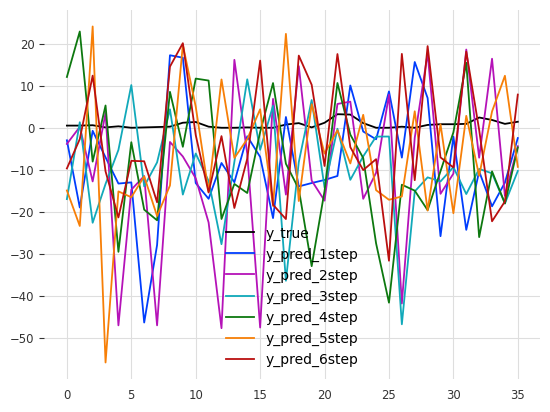

⭐️⭐️⭐️⭐️⭐️⭐️⭐️


,Date,Observed,1-month,2-month,3-month,4-month,5-month,6-month,City,RMSE_1-month,...,MAPE_4-month,MSE_4-month,RMSE_5-month,MAE_5-month,MAPE_5-month,MSE_5-month,RMSE_6-month,MAE_6-month,MAPE_6-month,MSE_6-month
167,2011-01-31,0.513699,-2.987344,-3.848776,-16.990391,12.095305,-14.928917,-9.687490,Quảng Ninh,15.787036,...,1.680528e+16,297.476547,16.760452,13.459167,1.178334e+16,280.912767,14.705395,13.153391,1.437523e+16,216.248647
168,2011-02-28,0.513699,-18.985734,0.198211,1.319700,22.917231,-23.380135,-2.706494,Quảng Ninh,15.787036,...,1.680528e+16,297.476547,16.760452,13.459167,1.178334e+16,280.912767,14.705395,13.153391,1.437523e+16,216.248647
169,2011-03-31,0.599316,-0.729342,-12.775316,-22.618447,-8.056386,24.112346,12.412036,Quảng Ninh,15.787036,...,1.680528e+16,297.476547,16.760452,13.459167,1.178334e+16,280.912767,14.705395,13.153391,1.437523e+16,216.248647
170,2011-04-30,0.085617,-7.043049,3.523872,-13.382883,5.302411,-55.882414,-10.376643,Quảng Ninh,15.787036,...,1.680528e+16,297.476547,16.760452,13.459167,1.178334e+16,280.912767,14.705395,13.153391,1.437523e+16,216.248647
171,2011-05-31,0.342464,-13.285656,-47.043946,-5.270614,-29.542425,-15.148266,-21.349205,Quảng Ninh,15.787036,...,1.680528e+16,297.476547,16.760452,13.459167,1.178334e+16,280.912767,14.705395,13.153391,1.437523e+16,216.248647


[I 2023-11-01 23:10:57,051] Trial 0 finished with value: 13.817166452397844 and parameters: {'dropout': 0.47972906001598953, 'n_epochs': 160, 'random_state': 10}. Best is trial 0 with value: 13.817166452397844.


13.817166452397844
Study statistics for : 
  Number of finished trials:  1
Best trial of city:  Quảng Ninh


In [33]:
#########################
# Main cell for optimize DL algorithm
#########################

model_name_list = [
     "BlockRNNModel",
     "NBEATSModel",
     "NHiTSModel",
     "TFTModel",
    # "TCNModel", #still bug
    
]

# Lưu thông tin traceback study và error city trong quá trình optimize
l_study_city ={}
l_errCity =[]

if __name__ == '__main__':
    for model_name in model_name_list: 
      print("⭐️ Model_name: ",model_name)
      best_param = pd.DataFrame()
      for city_index in range(len(cities)):
        print("⭐️ City: ",cities[city_index])
        # Use Tree-structured Parzen Estimator sampler to minimise RMSE
        sampler = optuna.samplers.TPESampler()
        study = optuna.create_study(sampler=sampler, direction='minimize', study_name = model_name)
        # truyền multiple param vào trong biến trial
        obj_func = lambda trial: objective(model_name, trial, cities[city_index])
        try:
          # Optimise over 100 trials
          study.optimize(obj_func, n_trials=args.ntry, n_jobs=args.njob)

          # Print results
          print("Study statistics for : ")
          print("  Number of finished trials: ", len(study.trials))
          print("Best trial of city: ",cities[city_index])

          best_trial = study.best_trial
          # lưu best param vào trong biến toàn cục
          if model_name == "NHiTSModel":
            one_city_param = pd.DataFrame({
                                'City':  [cities[city_index]],
                                'Alg_name': 'N-HiTS',
                                'Best_value': best_trial.value,
                                'n_try_opt': args.ntry,
                                'input_chunk_length' : args.look_back,
                                'output_chunk_length' : args.n_predicted_period_months,
                                'MaxPool1d' : best_trial.params['MaxPool1d'],
                                'dropout' : best_trial.params['dropout'],
                                'n_epochs' : best_trial.params['n_epochs'],
                                'random_state' : best_trial.params['random_state'],
                                })
          elif model_name == "TCNModel":
            one_city_param = pd.DataFrame({
                                'City':  [cities[city_index]],
                                'Alg_name': 'TCNModel',
                                'Best_value': best_trial.value,
                                'n_try_opt': args.ntry,
                                'input_chunk_length': args.look_back,
                                'output_chunk_length': args.n_predicted_period_months,
                                'n_epochs':best_trial.params['n_epochs'],
                                'num_filters':best_trial.params['num_filters'],
                                'weight_norm':best_trial.params['weight_norm'],
                                'dilation_base':best_trial.params['dilation_base'],
                                'dropout':best_trial.params['dropout'],
                                'learning_rate':best_trial.params['learning_rate'],
                                'year':best_trial.params['year'],
                                })
          elif model_name == "NBEATSModel":
            one_city_param = pd.DataFrame({
                                'City':  [cities[city_index]],
                                'Alg_name': 'NBeatsModel',
                                'Best_value': best_trial.value,
                                'n_try_opt': args.ntry,
                                'input_chunk_length': args.look_back,
                                'output_chunk_length': args.n_predicted_period_months,
                                'dropout':best_trial.params['dropout'],
                                'n_epochs':best_trial.params['n_epochs'],
                                'random_state':best_trial.params['random_state'],
                                })  
          elif model_name == "TFTModel":
            one_city_param = pd.DataFrame({
                                'City':  [cities[city_index]],
                                'Alg_name': 'TFTModel',
                                'Best_value': best_trial.value,
                                'n_try_opt': args.ntry,
                                'input_chunk_length': args.look_back,
                                'output_chunk_length': args.n_predicted_period_months,
                                'add_relative_index': True,
                                'dropout':best_trial.params['dropout'],
                                'n_epochs':best_trial.params['n_epochs'],
                                'random_state':best_trial.params['random_state']
                                })
          elif model_name == "BlockRNNModel":
            one_city_param = pd.DataFrame({
                                'City':  [cities[city_index]],
                                'Alg_name': 'BlockRNNModel',
                                'Best_value': best_trial.value,
                                'n_try_opt': args.ntry,
                                'input_chunk_length': args.look_back,
                                'output_chunk_length': args.n_predicted_period_months,
                                'hidden_dim': best_trial.params['hidden_dim'],
                                'n_rnn_layers': best_trial.params['n_rnn_layers'],
                                'dropout':best_trial.params['dropout'],
                                'n_epochs':best_trial.params['n_epochs'],
                                'random_state':best_trial.params['random_state'],
                                })
          # file_path = 'opt_results/opt_res_ml_26102023/261023_DF_opt_hyperparam_'+ model_name + '_'+str(nstep)+'-nstep.xlsx'
          folder_path = f'opt_results/opt_res_ml_26102023/{model_name}/'
          file_path = folder_path+ f'261023_DF_opt_hyperparam_{model_name}_multi-nstep.xlsx'
         
          if(os.path.isfile(file_path)):
              with pd.ExcelWriter(file_path,mode="a",engine="openpyxl",if_sheet_exists="overlay") as writer:
                  one_city_param.to_excel(writer, header=None, startrow=city_index+1,index=False)
          else:
              if(not (os.path.isdir(folder_path))):
                os.mkdir(folder_path)
              with pd.ExcelWriter(file_path,engine="openpyxl") as writer:
                  one_city_param.to_excel(writer, startrow=city_index,index=False)
        except:# có error thì lưu vào l_errCity để check lại sau 
          l_errCity.append(cities[city_index])
          #send_to_telegram(f'Tỉnh bị lỗi trong quá trình optimize bằng model {model_name}: {cities[city_index]}')

In [34]:
# send_to_telegram("Chạy xong optimize rùiii!!Vô check thuiii!!!" )